In [30]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

from matplotlib import pyplot as plt

from argparse import Namespace

import pandas as pd

In [33]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [34]:
from ml.utils.train_utils import train, test

In [35]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [36]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [37]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset
    ignore_cols = None,#['rb_up_var', 'rb_down_var', 'mcs_up_var', 'mcs_down_var'],
    test_size=0.2, # validation size 
    targets=['temp','pH','DissolvedOxygen','Conductivity','Turbidity','AmmoniaNitrogen'], # the target columns

    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=5, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fednova2", # federated aggregation algorithm
    epochs=5, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.5, # whether to clip grad norm
    reg1=1e-08, # l1 regularization
    reg2=1e-06, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=74962657, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [38]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(aggregation='fednova2', assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', epochs=5, fl_rounds=5, fraction=1.0, identifier='District', ignore_cols=None, local_early_stopping=False, local_patience=50, lr=0.001, max_grad_norm=0.5, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=True, reg1=1e-08, reg2=1e-06, seed=74962657, targets=['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity', 'AmmoniaNitrogen'], test_size=0.2, use_time_features=False, x_scaler='minmax', y_scaler='minmax')



In [39]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [40]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['Conductivity', 'Turbidity', 'pH', 'DissolvedOxygen']
    outlier_kwargs = {"upstream": (10, 90), "midstream": (10, 90), "downstream": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [41]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [42]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets, ignore_cols=args.ignore_cols)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=False,
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=False,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [43]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [44]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [45]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [46]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[0,1,3,7,8,2], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=False
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    if "fedprox" in args.aggregation:
        args.aggregation = "fedprox"
    elif "fednova" in args.aggregation:
        args.aggregation = "fednova"
    elif "fedavgm" in args.aggregation:
        args.aggregation = "fedavgm"
    elif "fedadagrad" in args.aggregation:
        args.aggregation = "fedadagrad"
    elif "fedyogi" in args.aggregation:
        args.aggregation = "fedyogi"
    elif "fedadam" in args.aggregation:
        args.aggregation = "fedadam"
    print(aggregation_params)
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [47]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [48]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [49]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scaler, # the scaler used to transform the targets
    idxs=[0,1,3,7,8,2], # the indices of our targets in X
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    val_nrmses = dict()
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        val_nrmses[cid] = val_nrmse
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)
    return val_nrmses

In [50]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def round_predictions_test(y_pred_test, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_test
    for dim in dims:
        y_pred_test[:, dim] = np.rint(y_pred_test[:, dim])
    return y_pred_test

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)
    
    if y_scaler is not None:
        y_test = y_scaler.inverse_transform(y_test)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
    
    # to zeroes
    y_pred_test[y_pred_test < 0.] = 0.
    
    if round_preds:
        y_pred_test = round_predictions_test(y_pred_test, dims)
    
    return y_test, y_pred_test

def predict(
            model,
            cid, 
            X_test,
            y_test,
            exogenous_data_test,
            plot,
            idxs=[0,1,2,3,4],
            apply_round=True,
            round_dimensions=[0, 3, 4],
            y_scaler=None
           ):
    
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break
    
    num_features = len(X_test[0][0])
    
    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, y_pred_test = test(
                model, test_loader, None, device=device
    )
    
    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test, y_scaler, round_preds=apply_round, dims=round_dimensions
    )
    
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, test_res_per_dim = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True
    )
    print(f"Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse}, rmse: {test_rmse}, mae {test_mae}, "
        f"r2: {test_r2}, nrmse: {test_nrmse}\n\n")
    
    
    if plot:
        make_plot(y_test, y_pred_test, title="Test", feature_names=args.targets, client=cid)
        
    return test_nrmse
    

In [51]:
def model_test(
    model, 
    data_paths, 
    x_scaler, 
    y_scaler,
    plot=True,
    idxs=[0,1,3,7,8,2], # the indices of our targets in X
    round_predictions=False,
    round_dimensions=[0, 3, 4],
):
    # In testing we should pre-process and post-process our data and
    # instruct our model to perform predictions
    
    # read the data
    test_nrmses = dict()
    for client in data_paths:
        df = read_data(client)
    
        if args.identifier not in df.columns:
            cid = os.path.splitext(os.path.basename(client))[0]
            df[args.identifier] = cid
        
        test_data = df.copy()
        
        # get X_test, y_test
        X_test, y_test = to_Xy(test_data, targets=args.targets, ignore_cols=args.ignore_cols)
        
        # scale features, targets
        X_test = scale_features(X_test, scaler=x_scaler, per_area=False)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False)
        
        # generate time lags
        X_test = generate_time_lags(X_test, args.num_lags)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True)
        
        # get datetime features (if specified)
        date_time_df_test = time_to_feature(
            X_test, args.use_time_features, identifier=args.identifier
        )
        
        # get statistics as features (if specified)
        stats_df_test = assign_statistics(X_test, args.assign_stats, args.num_lags,
                          targets=args.targets, identifier=args.identifier)
    
        if date_time_df_test is not None or stats_df_test is not None:
            exogenous_data_test = pd.concat([date_time_df_test, stats_df_test], axis=1)
            exogenous_data_test = exogenous_data_test.loc[:, ~exogenous_data_test.columns.duplicated()].copy()
        else:
            exogenous_data_test = None
        
        # transform to numpy
        if exogenous_data_test is not None:
            exogenous_data_test = get_exogenous_data_by_area(
                exogenous_data_test, identifier=args.identifier
            )
            
            for cid in exogenous_data_test:
                exogenous_data_test[cid] = exogenous_data_test[cid].to_numpy()
        
        # remove identifiers
        X_test, y_test = remove_identifiers(X_test, y_test)
        
        num_features = len(X_test.columns) // args.num_lags
        
        # to timeseries representation
        X_test = to_timeseries_rep(X_test.to_numpy(), args.num_lags, num_features=num_features)
        
        y_test = y_test.to_numpy()
        
        if exogenous_data_test is not None:
            assert len(exogenous_data_test) == 1
            exogenous_data_test = exogenous_data_test[next(iter(exogenous_data_test))]
            
        # make predictions
        tmp = predict(model, cid, X_test, y_test, exogenous_data_test, plot, idxs, y_scaler=y_scaler)
        
        if "test" in cid:
            tmp_cid = cid.split("_")
            for s_t in tmp_cid:
                if s_t != "test":
                    cid = s_t
                    break
        test_nrmses[cid] = tmp
    return test_nrmses

In [52]:
test_nrmses = dict()
val_nrmses = dict()

In [53]:
def make_pipeline():
    seed_all()
    X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing()
    X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

    input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

    model = get_model(model=args.model_name,
                      input_dim=input_dim,
                      out_dim=y_train.shape[1],
                      lags=args.num_lags,
                      exogenous_dim=exogenous_dim,
                      seed=args.seed)
    print("USING SEED", args.seed)

    # federated local params
    local_train_params = {"epochs": args.epochs, 
                          "optimizer": args.optimizer,
                          "lr": args.lr,
                          "criterion": args.criterion, 
                          "early_stopping": args.local_early_stopping,
                          "patience": args.local_patience,
                          "device": device,
                          "max_grad_norm": args.max_grad_norm,
                          "reg1": args.reg1,
                          "reg2": args.reg2
                          }
    aggregation_params = None
    agg_name = args.aggregation
    print(agg_name)
    if "fednova" in args.aggregation:
        aggregation_params = dict()
        if args.aggregation == "fednova1":
            aggregation_params["rho"] = 0.001
        elif args.aggregation == "fednova2":
            aggregation_params["rho"] = 0.01
        elif args.aggregation == "fednova3":
            aggregation_params["rho"] = 0.1
        elif args.aggregation == "fednova4":
            aggregation_params["rho"] = 0.99
    
    print(local_train_params)
    global_model, history = fit(
        model,
        client_X_train,
        client_y_train, 
        client_X_val, 
        client_y_val, 
        local_train_params=local_train_params,
        aggregation_params=aggregation_params
    )

    tmp = inference(
        global_model,
        client_X_train, 
        client_y_train,
        client_X_val, 
        client_y_val,
        exogenous_data_train, 
        exogenous_data_val,
        y_scaler,
        plot=True
    )
    val_nrmses[agg_name] = tmp
    
    test_data_paths = [
    "../dataset/upstream_test.csv",
    "../dataset/midstream_test.csv",
    "../dataset/downstream_test.csv"
]
    
    tmp = model_test(global_model, 
           test_data_paths, 
           x_scaler, y_scaler,
           round_predictions=True,
                     plot=True
          )
    test_nrmses[agg_name] = tmp
    return global_model, history, x_scaler, y_scaler

In [54]:
args.model_name = "lstm"

INFO logger 2024-06-03 11:21:18,836 | data_utils.py:383 | Observations info in upstream
INFO logger 2024-06-03 11:21:18,837 | data_utils.py:384 | 	Total number of samples:  4863
INFO logger 2024-06-03 11:21:18,837 | data_utils.py:385 | 	Number of samples for training: 3891
INFO logger 2024-06-03 11:21:18,837 | data_utils.py:386 | 	Number of samples for validation:  972
INFO logger 2024-06-03 11:21:18,840 | data_utils.py:383 | Observations info in midstream
INFO logger 2024-06-03 11:21:18,840 | data_utils.py:384 | 	Total number of samples:  4930
INFO logger 2024-06-03 11:21:18,841 | data_utils.py:385 | 	Number of samples for training: 3944
INFO logger 2024-06-03 11:21:18,841 | data_utils.py:386 | 	Number of samples for validation:  986
INFO logger 2024-06-03 11:21:18,843 | data_utils.py:383 | Observations info in downstream
INFO logger 2024-06-03 11:21:18,844 | data_utils.py:384 | 	Total number of samples:  4920
INFO logger 2024-06-03 11:21:18,844 | data_utils.py:385 | 	Number of sample

USING SEED 74962657
fednova2
{'epochs': 5, 'optimizer': 'adam', 'lr': 0.001, 'criterion': 'mse', 'early_stopping': False, 'patience': 50, 'device': 'cuda', 'max_grad_norm': 0.5, 'reg1': 1e-08, 'reg2': 1e-06}
{'rho': 0.01}


INFO logger 2024-06-03 11:21:20,370 | server.py:86 | Starting FL rounds
INFO logger 2024-06-03 11:21:20,371 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['upstream', 'downstream', 'midstream']
INFO logger 2024-06-03 11:21:21,534 | train_utils.py:142 | Best Loss: 0.0010551423368793515
INFO logger 2024-06-03 11:21:22,880 | train_utils.py:142 | Best Loss: 0.00016675653314749563
INFO logger 2024-06-03 11:21:24,175 | train_utils.py:142 | Best Loss: 0.00020403252555759716
INFO logger 2024-06-03 11:21:24,279 | server.py:191 | [Global round 1] Aggregating local models...
INFO logger 2024-06-03 11:21:24,644 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['downstream', 'midstream', 'upstream']
INFO logger 2024-06-03 11:21:25,763 | train_utils.py:142 | Best Loss: 0.00014045074662419316
INFO logger 2024-06-03 11:21:27,004 | train_utils.py:142 | Best Loss: 0.00016085027152153313
INFO logger 2024-06-03 11:21:28,227 | train_utils.py:142 | Best Loss: 0.000922804531832

Prediction on upstream
Prediction on midstream
Prediction on downstream


INFO logger 2024-06-03 11:21:48,970 | helpers.py:60 | Metrics for dimension: 0
	mse: 2.020545482635498, rmse: 1.4214589275232323, mae: 1.0321669578552246, r^2: 0.9257389812732504, nrmse: 0.05429973797047905
INFO logger 2024-06-03 11:21:48,972 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.21599571406841278, rmse: 0.464753390593778, mae: 0.36543864011764526, r^2: 0.7014084922627076, nrmse: 0.06156651428556322
INFO logger 2024-06-03 11:21:48,974 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.9376245141029358, rmse: 0.9683101332233056, mae: 0.7728038430213928, r^2: 0.6038043898332885, nrmse: 0.13077424903480814
INFO logger 2024-06-03 11:21:48,976 | helpers.py:60 | Metrics for dimension: 3
	mse: 45898.91796875, rmse: 214.24032759672022, mae: 167.64080810546875, r^2: -70.60036338068267, nrmse: 1.333137430760625
INFO logger 2024-06-03 11:21:48,978 | helpers.py:60 | Metrics for dimension: 4
	mse: 9.184404373168945, rmse: 3.030578224228661, mae: 2.1362428665161133, r^2: 0.8046399936297


Final Prediction on upstream (Inference Stage)
[Train]: mse: 7651.923828125, rmse: 87.47527552471612, mae 28.6705265045166, r2: -11.150344381221666, nrmse: 0.8141604151731804
[Val]: mse: 3487.359619140625, rmse: 59.053870483996434, mae 21.682518005371094, r2: -11.987894981136401, nrmse: 0.9061026255800192




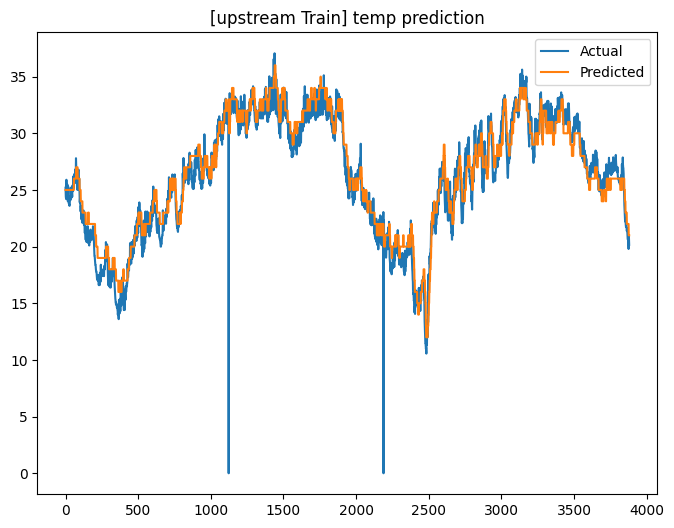

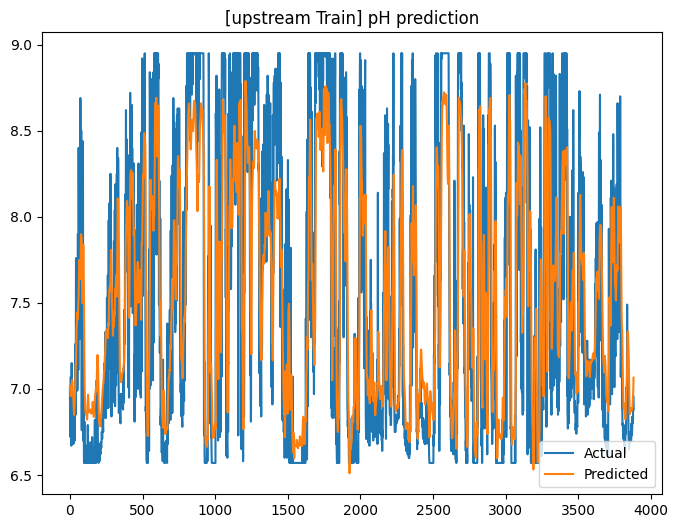

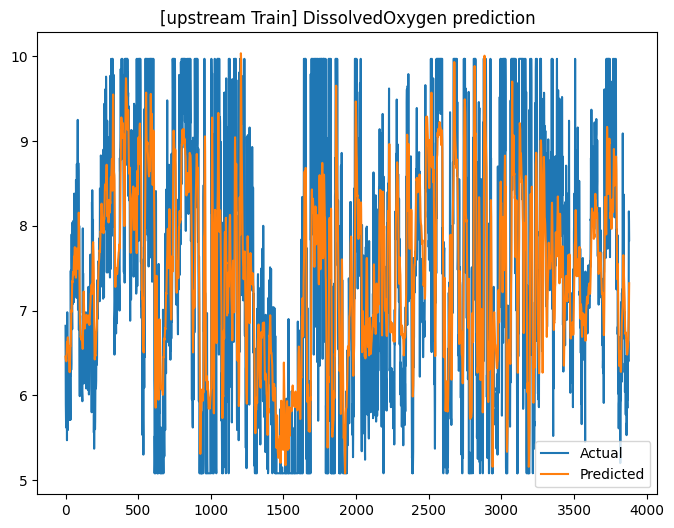

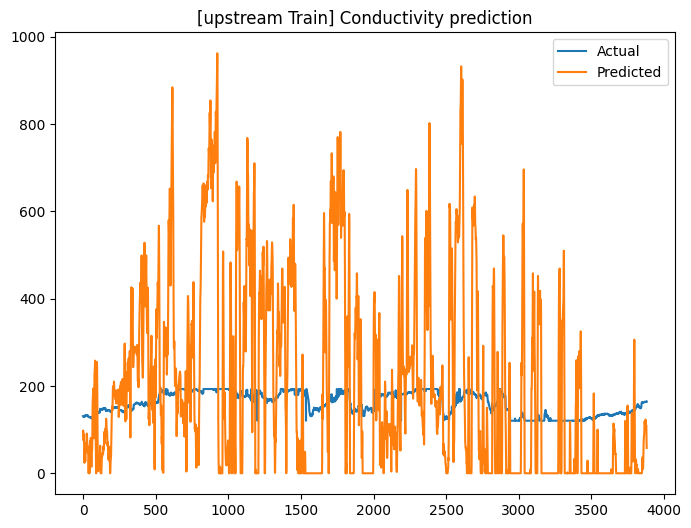

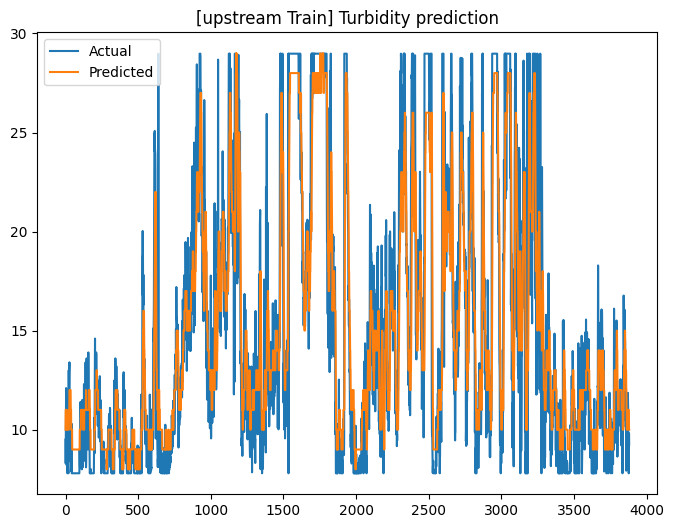

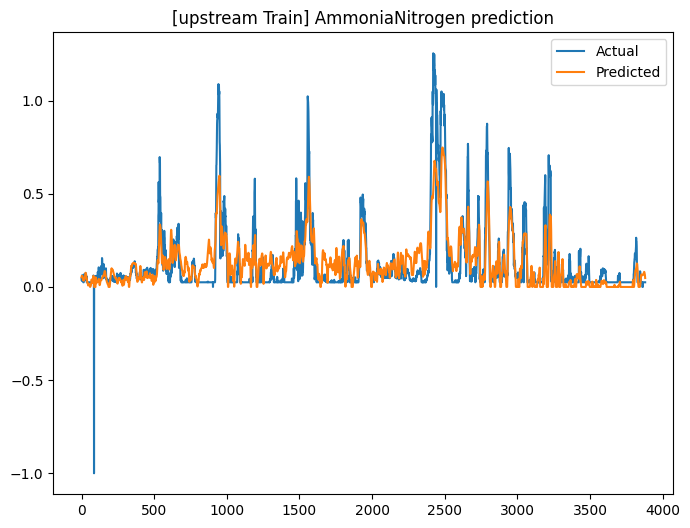

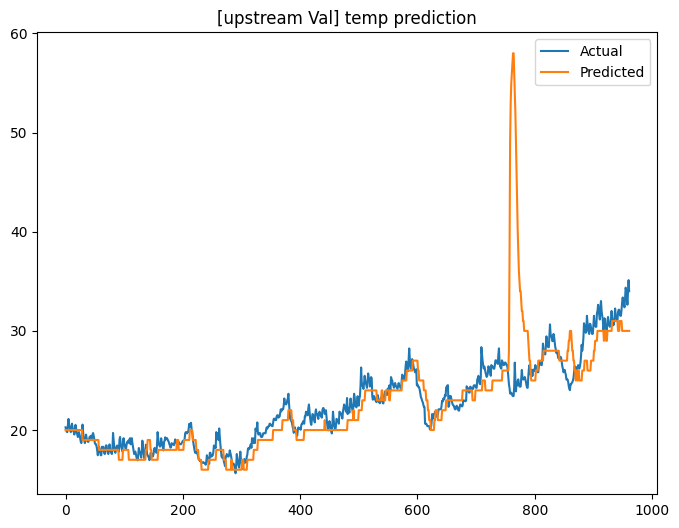

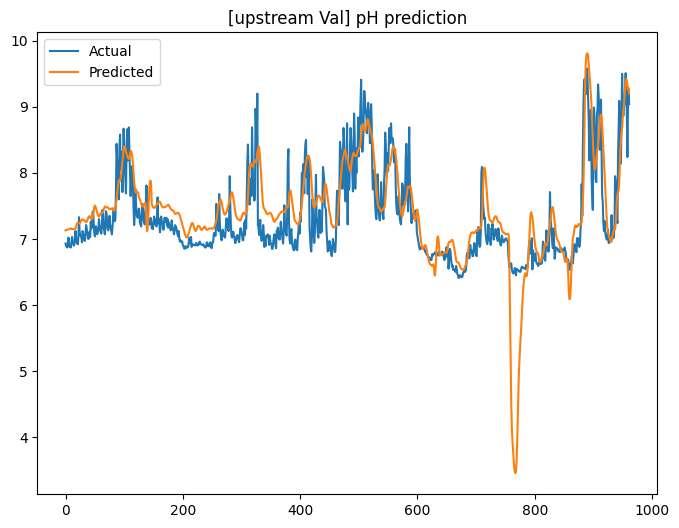

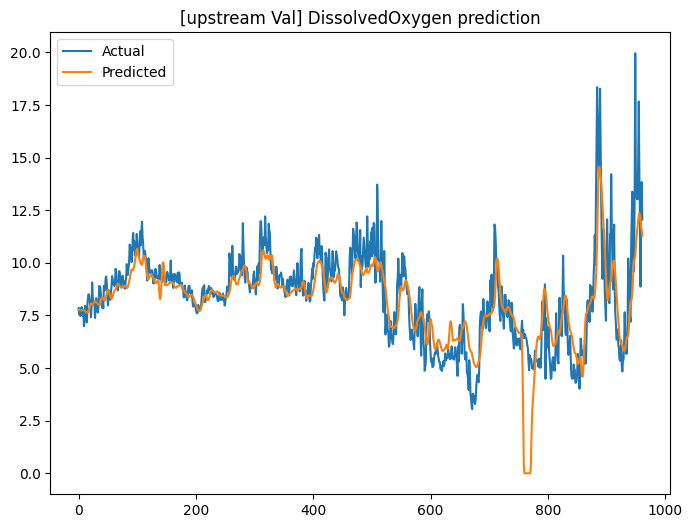

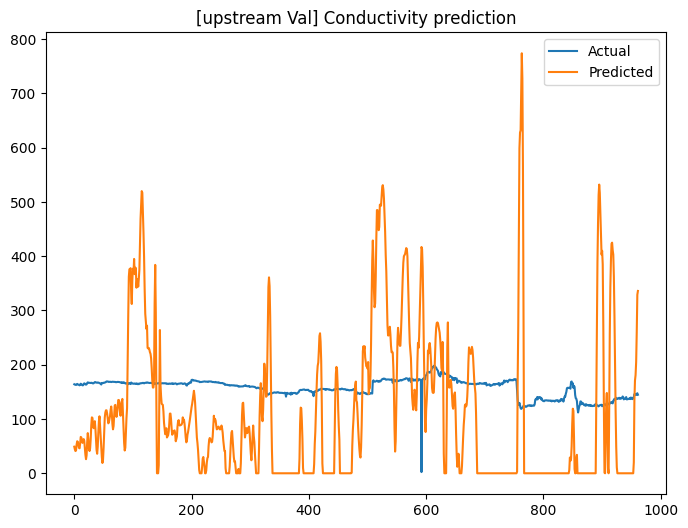

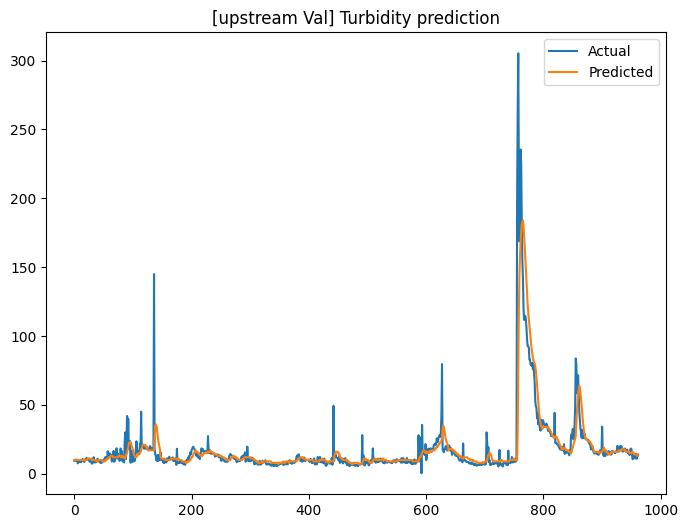

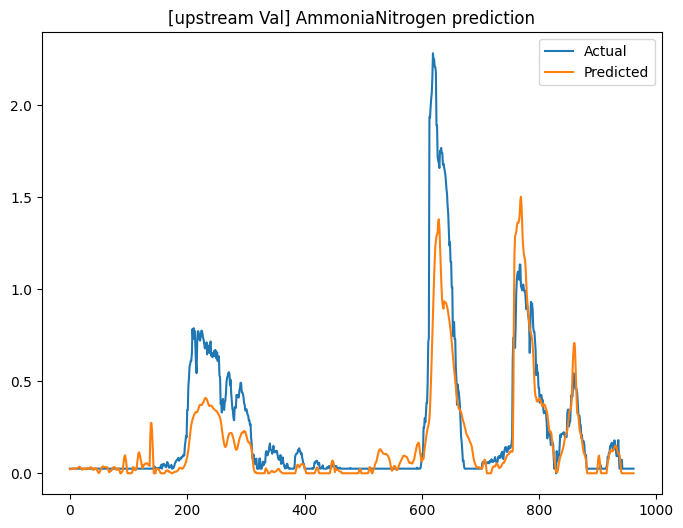

INFO logger 2024-06-03 11:21:50,635 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.2403616905212402, rmse: 1.1137152645632726, mae: 0.8571276068687439, r^2: 0.9538615515443902, nrmse: 0.04246726983330769
INFO logger 2024-06-03 11:21:50,636 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.1191648542881012, rmse: 0.3452026278696343, mae: 0.25978121161460876, r^2: 0.5177214666311594, nrmse: 0.04696441283175452
INFO logger 2024-06-03 11:21:50,638 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.360620379447937, rmse: 1.1664563341368321, mae: 0.9147858619689941, r^2: 0.6552493263886376, nrmse: 0.1515519962134076
INFO logger 2024-06-03 11:21:50,640 | helpers.py:60 | Metrics for dimension: 3
	mse: 20079.705078125, rmse: 141.70287604041422, mae: 125.30899810791016, r^2: -23.998936569804513, nrmse: 0.7310519892977918
INFO logger 2024-06-03 11:21:50,641 | helpers.py:60 | Metrics for dimension: 4
	mse: 3.8424110412597656, rmse: 1.9602068873615779, mae: 1.5544178485870361, r^2: 0.723169923


Final Prediction on midstream (Inference Stage)
[Train]: mse: 3347.701904296875, rmse: 57.85932858491252, mae 21.49159049987793, r2: -3.4227399337287134, nrmse: 0.6374167127677797
[Val]: mse: 12960.0283203125, rmse: 113.84212015028753, mae 36.556976318359375, r2: -28.224334797635635, nrmse: 0.8542392232014242




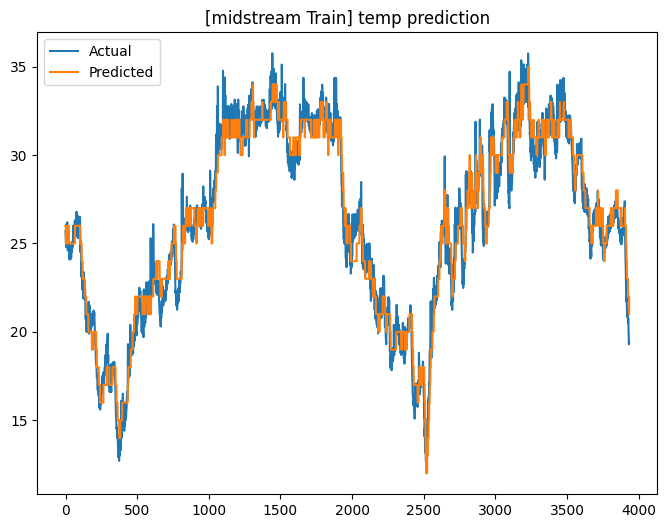

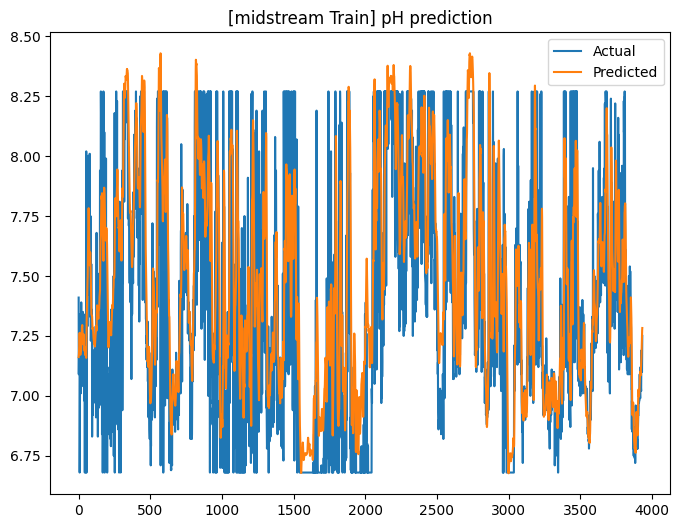

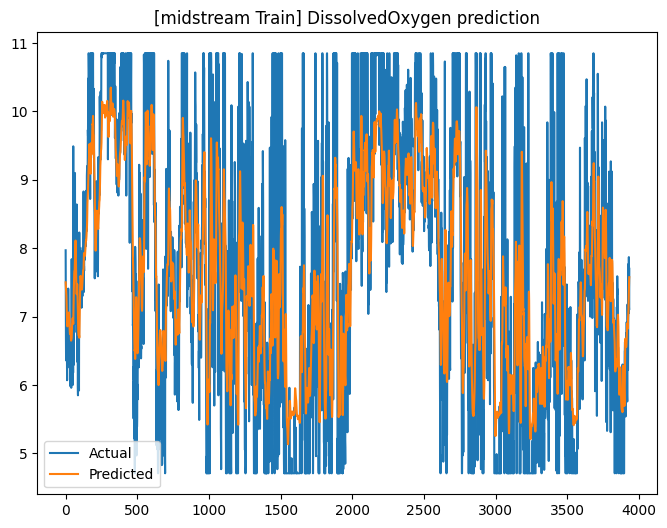

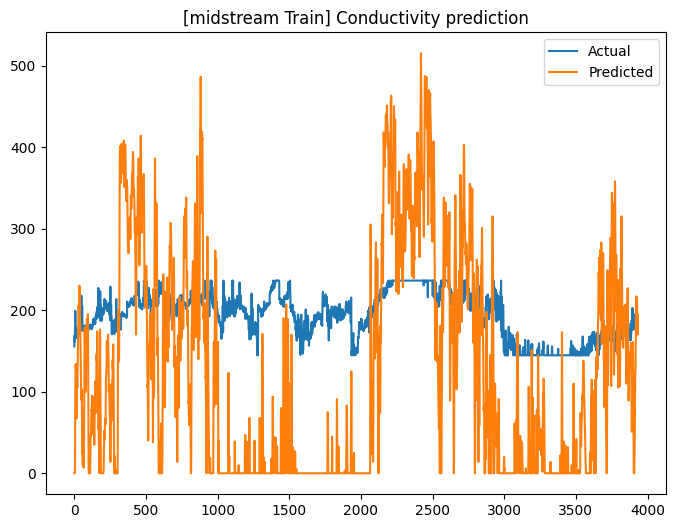

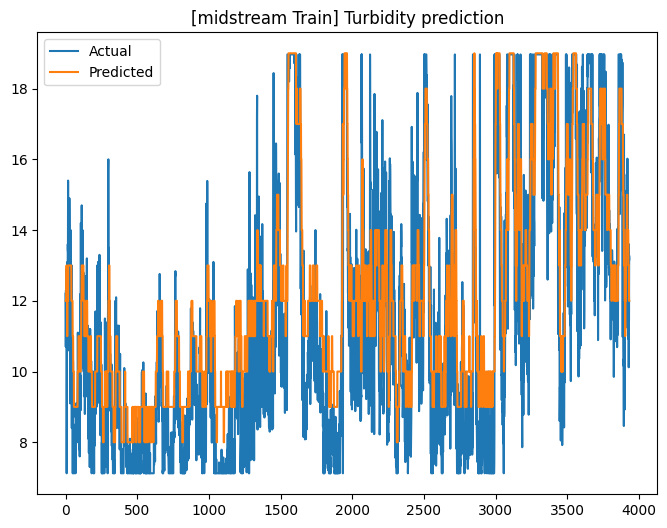

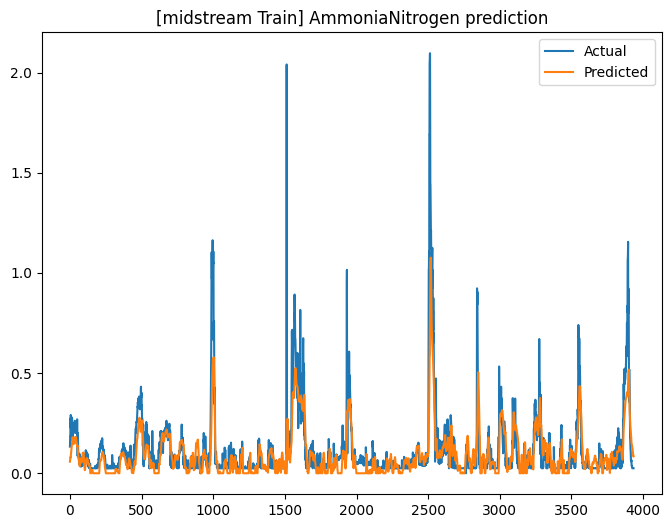

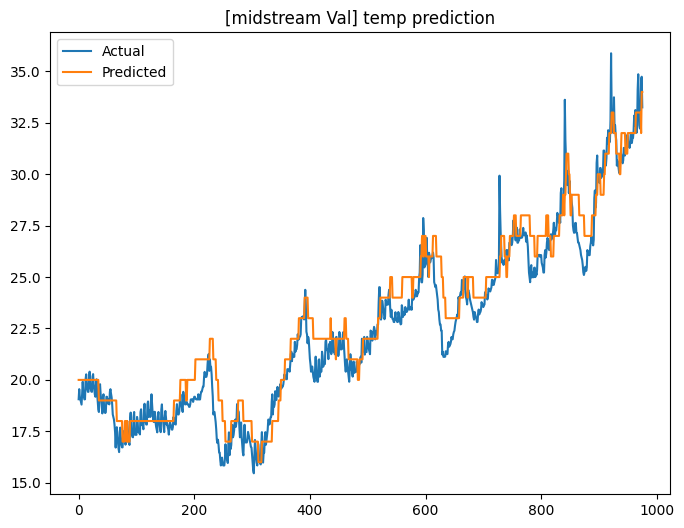

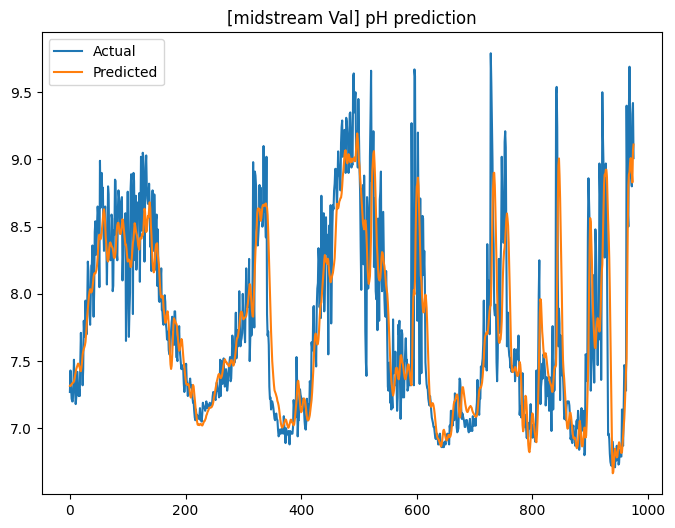

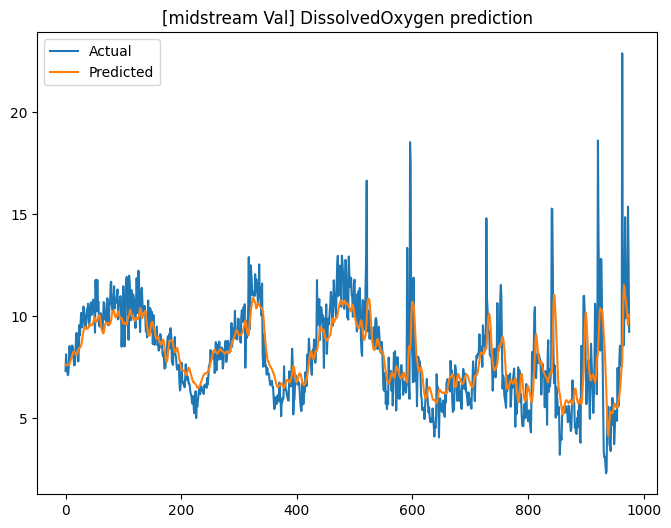

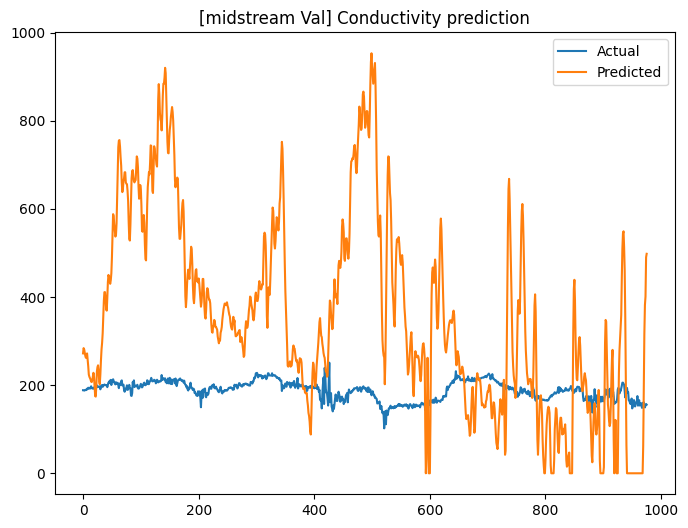

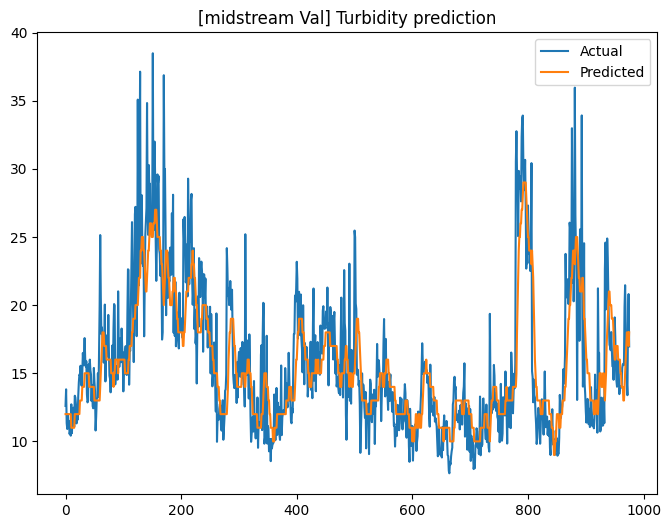

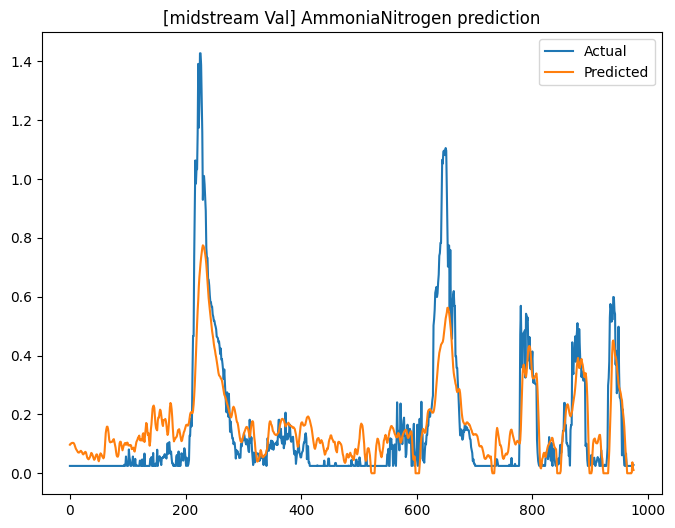

INFO logger 2024-06-03 11:21:52,251 | helpers.py:60 | Metrics for dimension: 0
	mse: 3.3861844539642334, rmse: 1.8401588121584054, mae: 1.2752267122268677, r^2: 0.8569344934433771, nrmse: 0.0699908035352509
INFO logger 2024-06-03 11:21:52,253 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.21263979375362396, rmse: 0.4611288255505439, mae: 0.34970206022262573, r^2: 0.36569067940723154, nrmse: 0.06369518899002431
INFO logger 2024-06-03 11:21:52,254 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.061892032623291, rmse: 1.435928978962153, mae: 1.1335699558258057, r^2: 0.4691811605422951, nrmse: 0.2099004183556026
INFO logger 2024-06-03 11:21:52,256 | helpers.py:60 | Metrics for dimension: 3
	mse: 7199981.5, rmse: 2683.278125726068, mae: 1423.61767578125, r^2: 0.38056479240374863, nrmse: 1.4925599793925868
INFO logger 2024-06-03 11:21:52,257 | helpers.py:60 | Metrics for dimension: 4
	mse: 13.011429786682129, rmse: 3.6071359534514538, mae: 2.537625551223755, r^2: 0.5894466677199888, n


Final Prediction on downstream (Inference Stage)
[Train]: mse: 1199996.625, rmse: 1095.443574539556, mae 238.1678466796875, r2: 0.5219149563793165, nrmse: 0.8658286051278771
[Val]: mse: 72345.6796875, rmse: 268.9715220752933, mae 49.6387825012207, r2: 0.5748831334844189, nrmse: 0.959174518618546




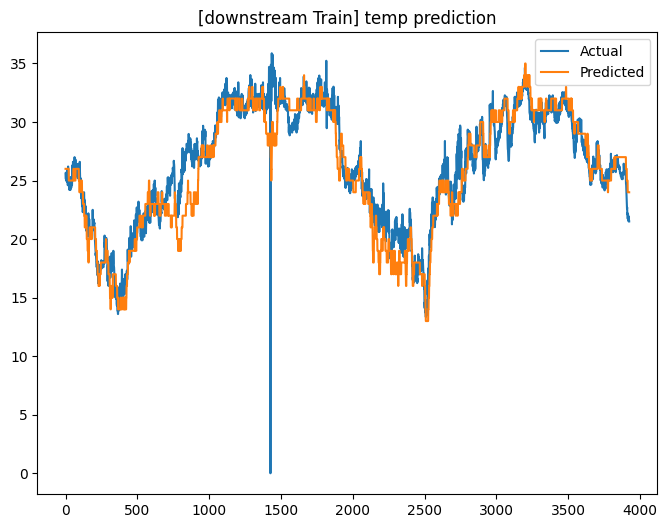

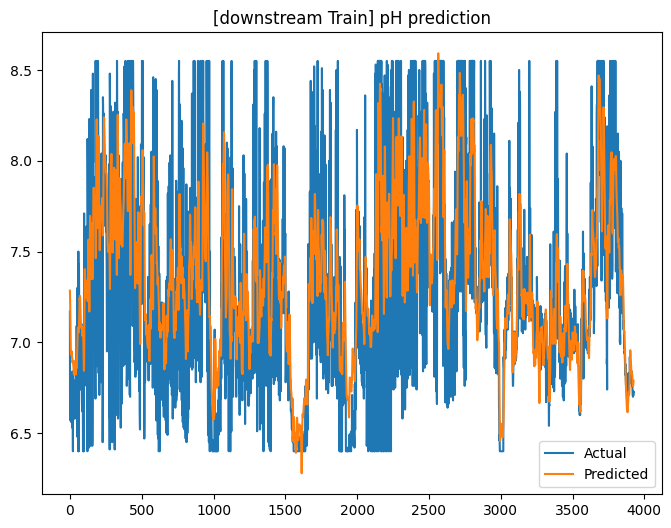

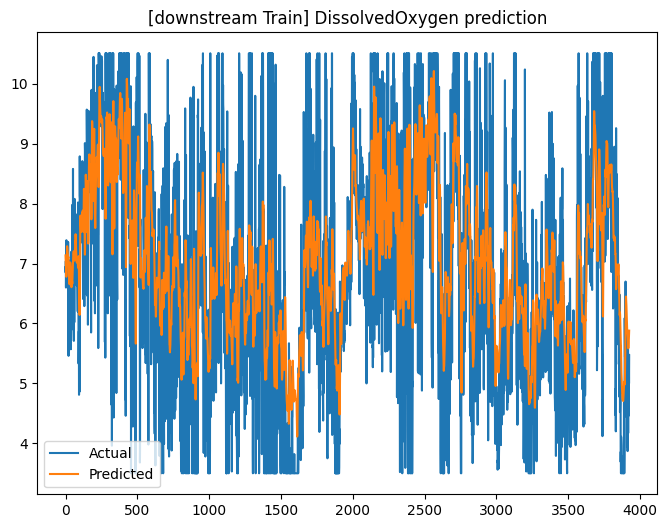

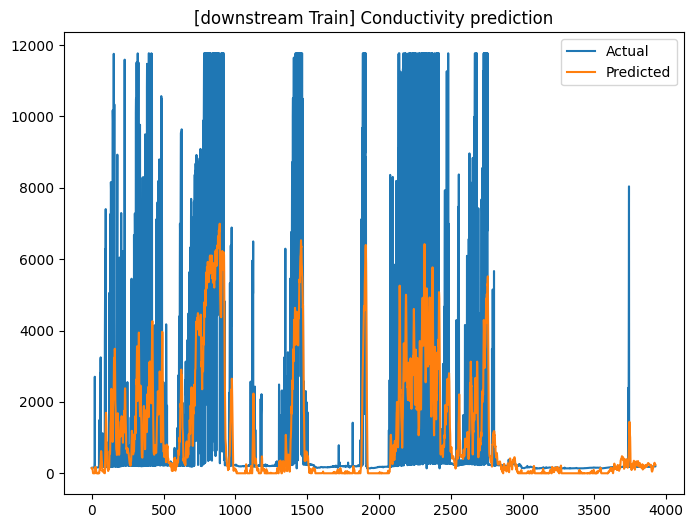

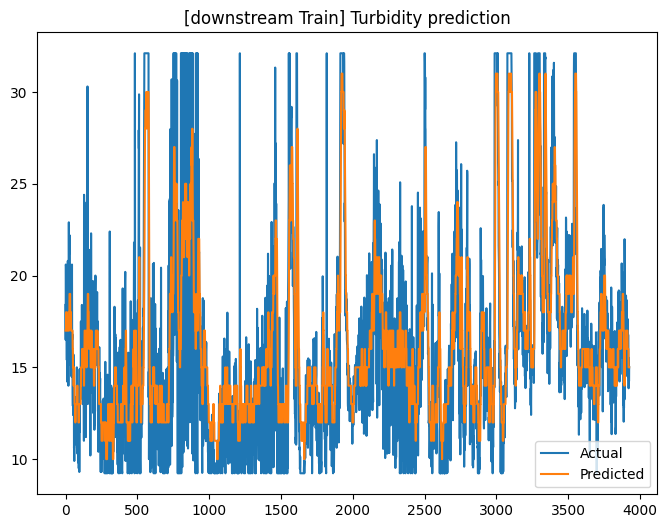

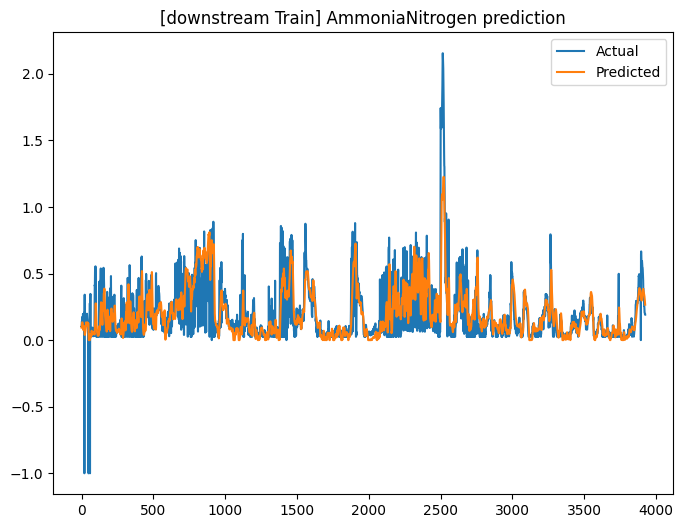

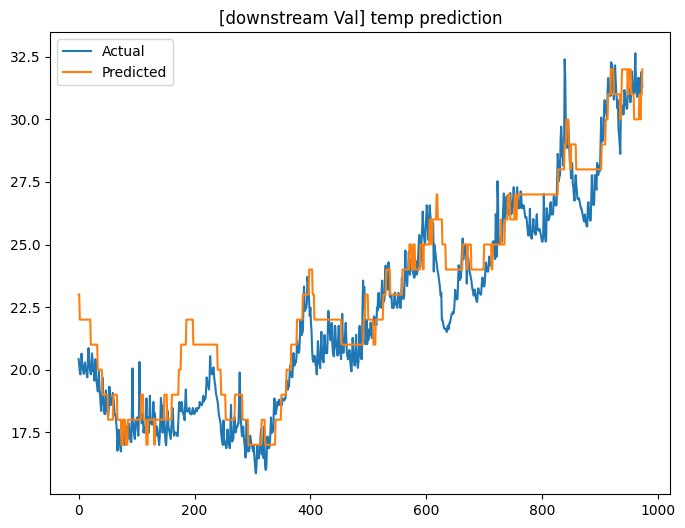

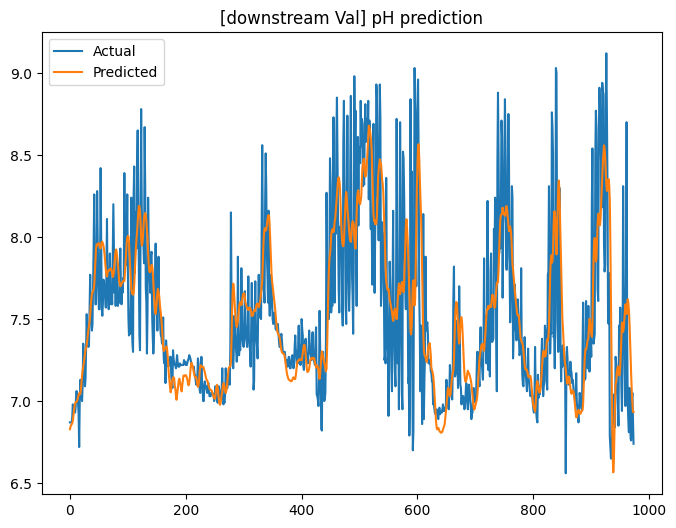

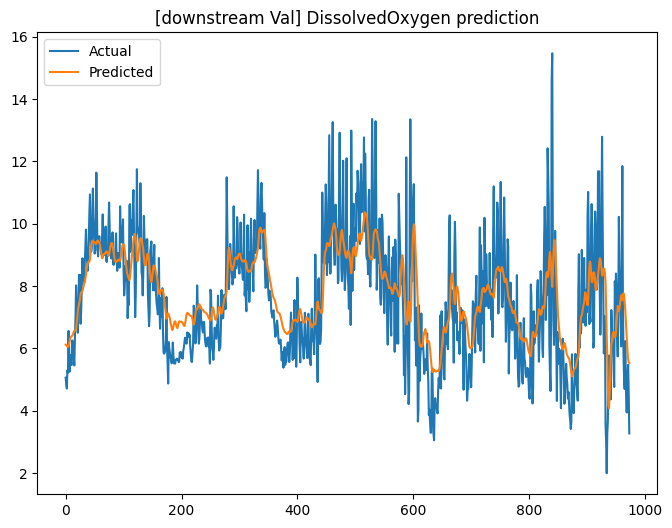

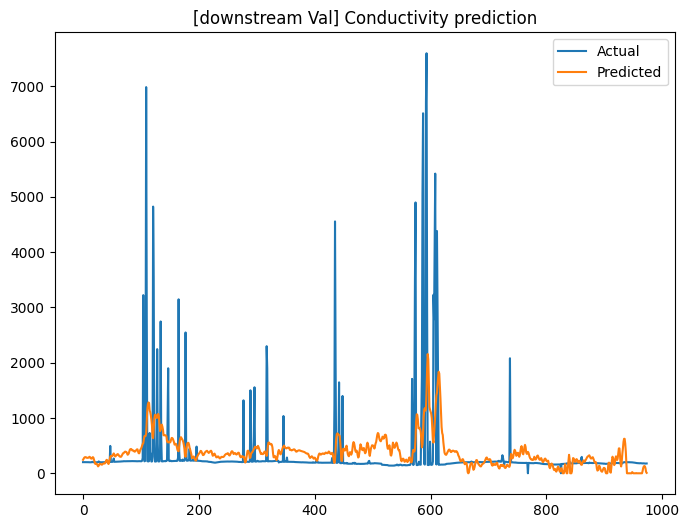

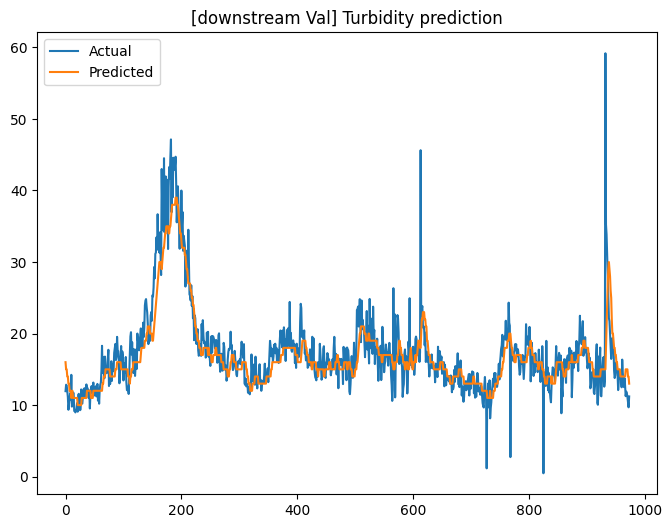

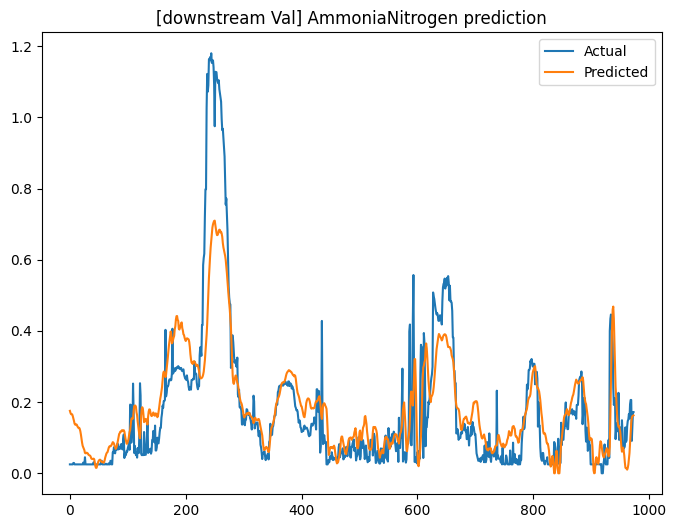

INFO logger 2024-06-03 11:21:55,108 | helpers.py:60 | Metrics for dimension: 0
	mse: 20.932201385498047, rmse: 4.5751722793243585, mae: 1.8710057735443115, r^2: -0.20802186071905004, nrmse: 0.161203760354598
INFO logger 2024-06-03 11:21:55,111 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.3965510427951813, rmse: 0.6297229889365492, mae: 0.47072502970695496, r^2: 0.5644188543830158, nrmse: 0.08828905864642314
INFO logger 2024-06-03 11:21:55,112 | helpers.py:60 | Metrics for dimension: 2
	mse: 3.941528558731079, rmse: 1.9853283251722067, mae: 1.3828778266906738, r^2: 0.49159214903214155, nrmse: 0.247638268105814
INFO logger 2024-06-03 11:21:55,113 | helpers.py:60 | Metrics for dimension: 3
	mse: 15436.33203125, rmse: 124.2430361479065, mae: 111.93557739257812, r^2: -80.2458112278408, nrmse: 1.1649969752583398
INFO logger 2024-06-03 11:21:55,115 | helpers.py:60 | Metrics for dimension: 4
	mse: 668.1431274414062, rmse: 25.84846470182332, mae: 6.655154705047607, r^2: 0.4053893225840063

Final Prediction in upstream
[Test]: mse: 2688.296142578125, rmse: 51.84878149559665, mae 20.39711570739746, r2: -13.303223082175471, nrmse: 1.3303598136615828




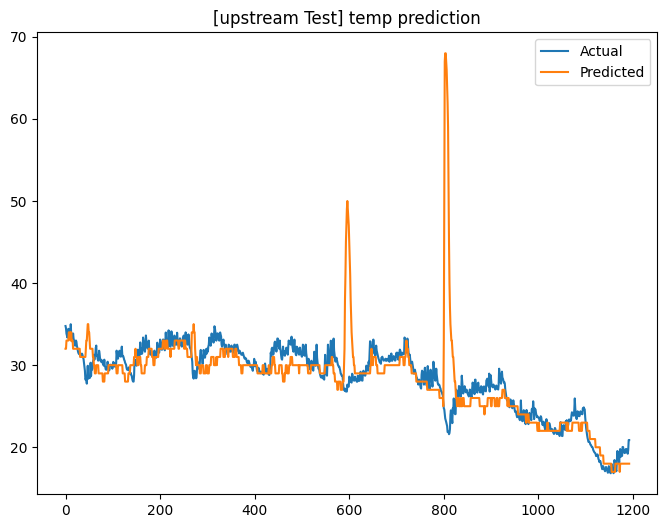

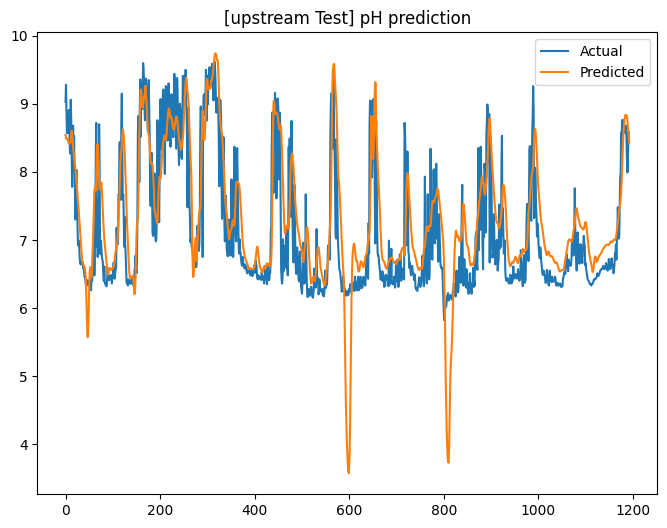

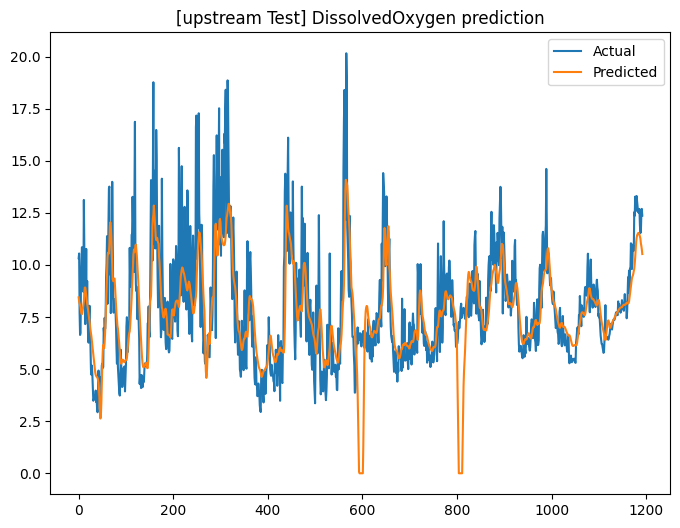

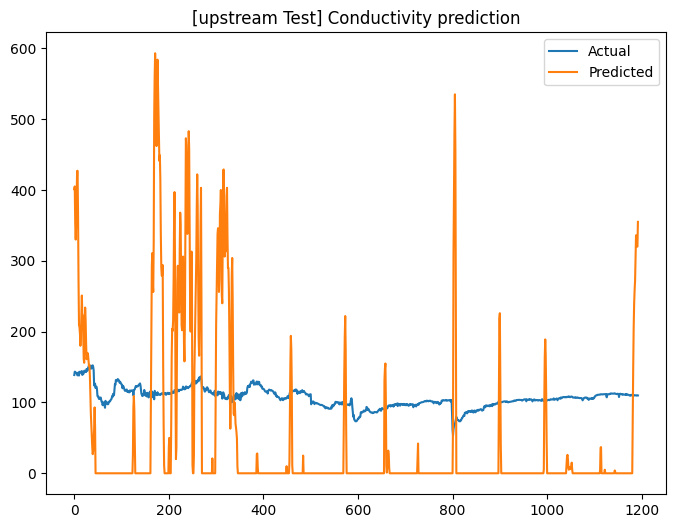

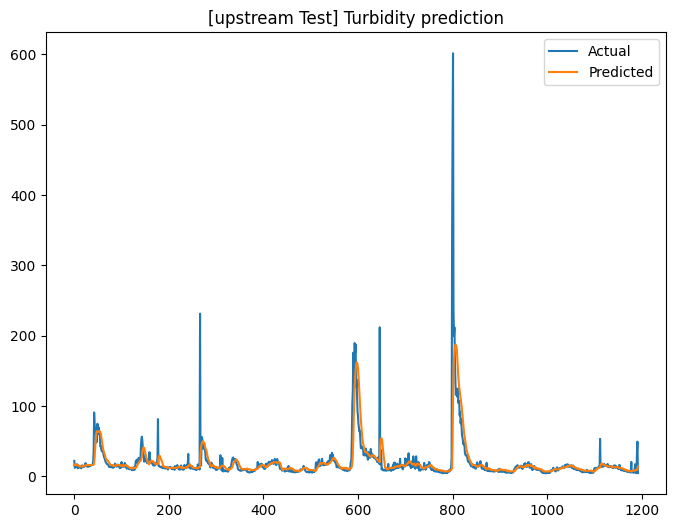

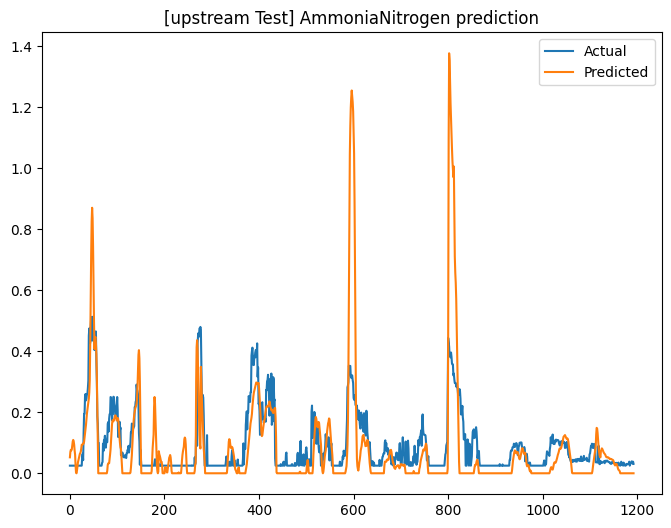

INFO logger 2024-06-03 11:21:56,598 | helpers.py:60 | Metrics for dimension: 0
	mse: 8.86886978149414, rmse: 2.978064771205311, mae: 1.8472979068756104, r^2: 0.540907212566079, nrmse: 0.10579539184850281
INFO logger 2024-06-03 11:21:56,599 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.22591644525527954, rmse: 0.4753066854729476, mae: 0.32621923089027405, r^2: 0.2223288500054328, nrmse: 0.06713147531887341
INFO logger 2024-06-03 11:21:56,600 | helpers.py:60 | Metrics for dimension: 2
	mse: 3.3599636554718018, rmse: 1.8330203641726956, mae: 1.2013070583343506, r^2: 0.48548277435553944, nrmse: 0.2642082556518078
INFO logger 2024-06-03 11:21:56,601 | helpers.py:60 | Metrics for dimension: 3
	mse: 16956.34765625, rmse: 130.2165414079563, mae: 120.36473846435547, r^2: -37.45554401806282, nrmse: 1.01886647755291
INFO logger 2024-06-03 11:21:56,603 | helpers.py:60 | Metrics for dimension: 4
	mse: 240.3505401611328, rmse: 15.503242891767284, mae: 7.962373733520508, r^2: 0.38775602439708423

Final Prediction in midstream
[Test]: mse: 2868.1953125, rmse: 53.555534844682484, mae 21.962854385375977, r2: -6.130649937273703, nrmse: 0.9506704535764042




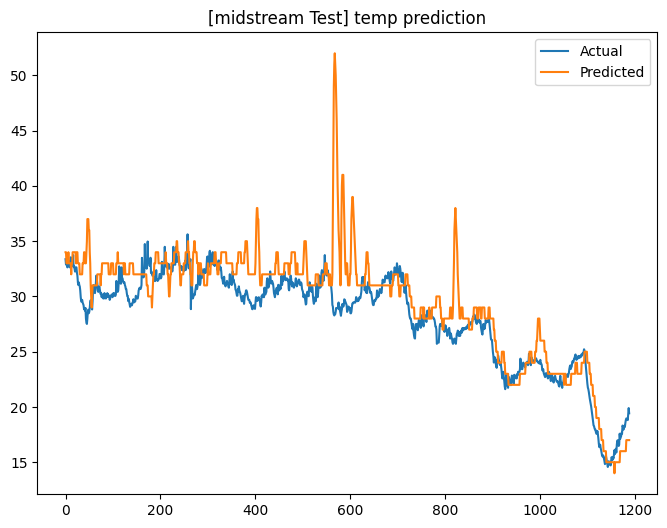

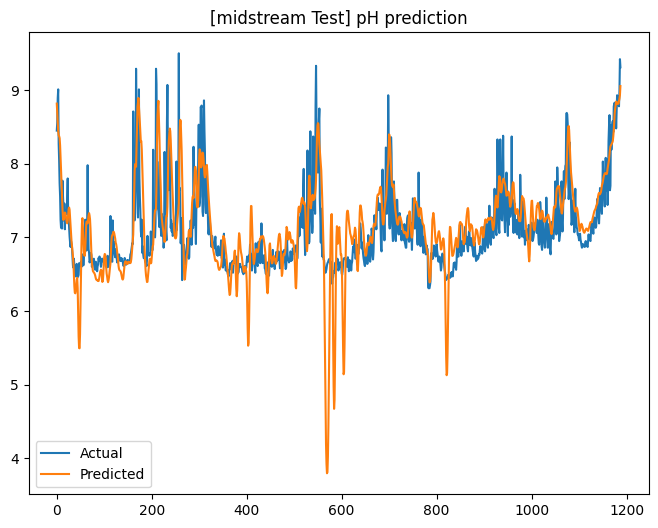

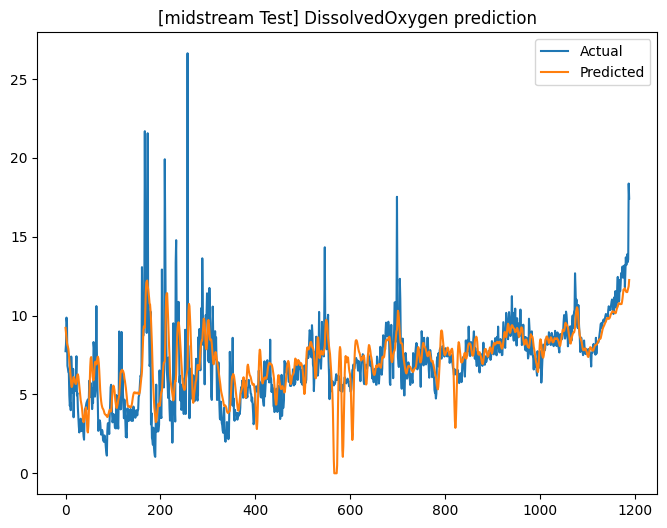

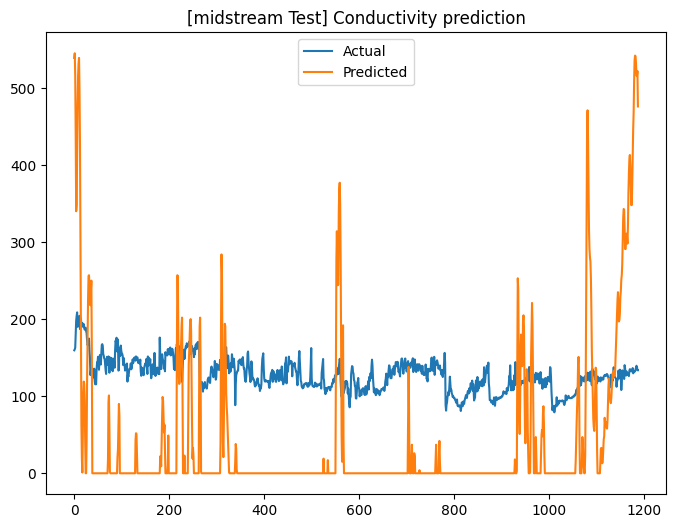

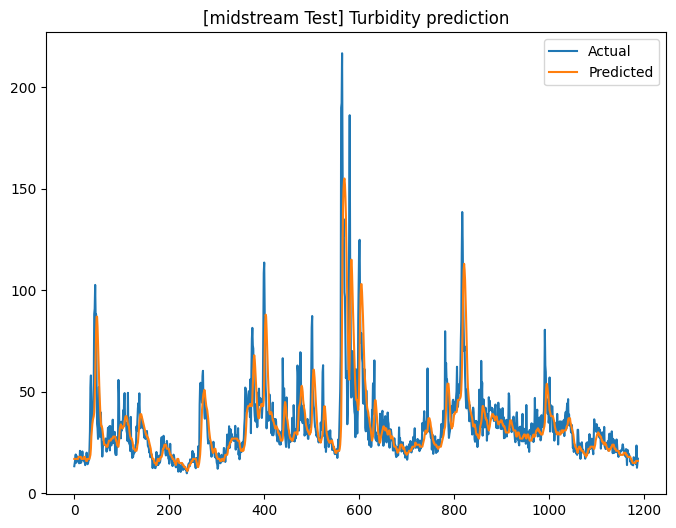

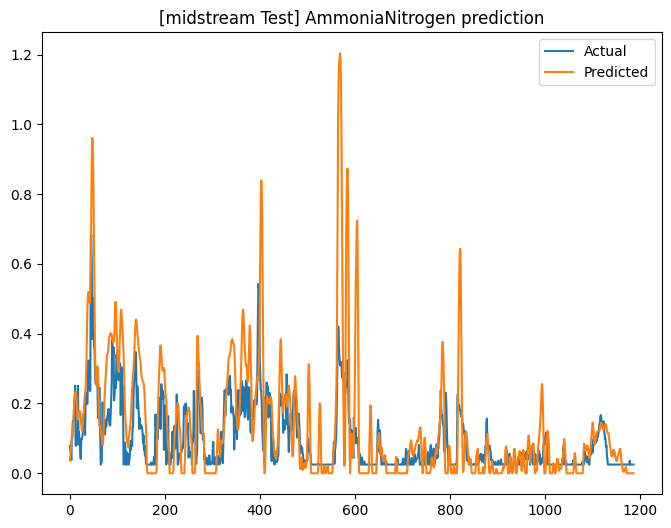

INFO logger 2024-06-03 11:21:58,016 | helpers.py:60 | Metrics for dimension: 0
	mse: 8.474169731140137, rmse: 2.9110427223144866, mae: 1.4762095212936401, r^2: 0.4838711693116696, nrmse: 0.10381626864705813
INFO logger 2024-06-03 11:21:58,018 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.20998163521289825, rmse: 0.4582375314320055, mae: 0.3286190927028656, r^2: 0.17247292364765043, nrmse: 0.06581133893030289
INFO logger 2024-06-03 11:21:58,020 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.1661293506622314, rmse: 1.4717776158993015, mae: 1.065424919128418, r^2: 0.4349664168196422, nrmse: 0.22142631722777334
INFO logger 2024-06-03 11:21:58,020 | helpers.py:60 | Metrics for dimension: 3
	mse: 16385.544921875, rmse: 128.00603470881754, mae: 120.74259948730469, r^2: -32.57154551952594, nrmse: 0.9508496823543462
INFO logger 2024-06-03 11:21:58,023 | helpers.py:60 | Metrics for dimension: 4
	mse: 439.63897705078125, rmse: 20.96756965055276, mae: 7.429412364959717, r^2: 0.11371968991

Final Prediction in downstream
[Test]: mse: 2806.008544921875, rmse: 52.97177120808662, mae 21.852022171020508, r2: -5.439789288616748, nrmse: 1.0266414610361831




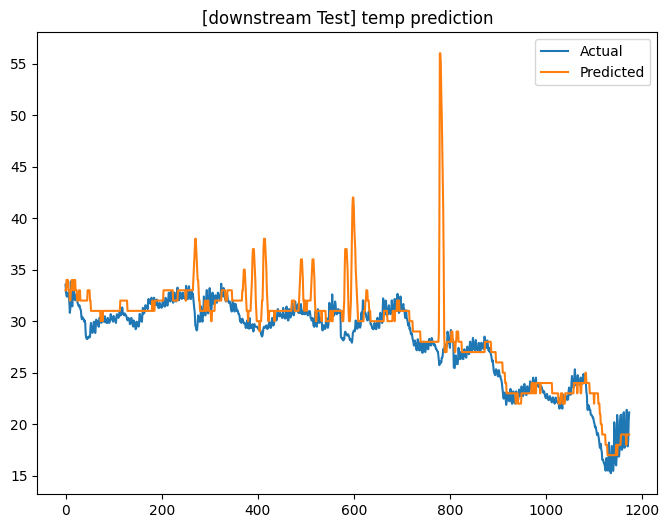

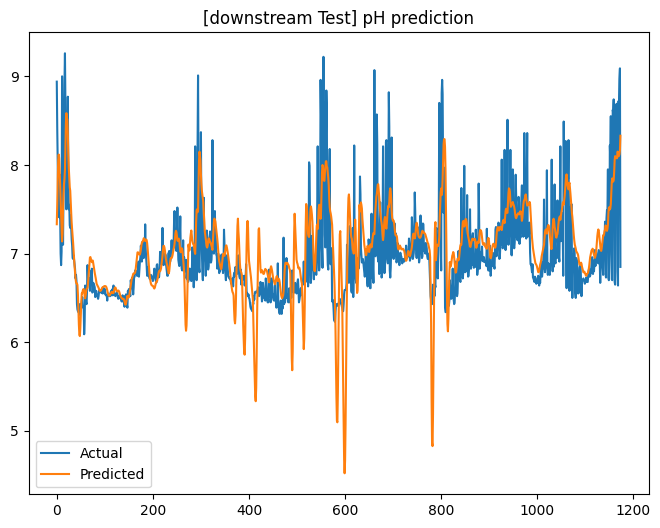

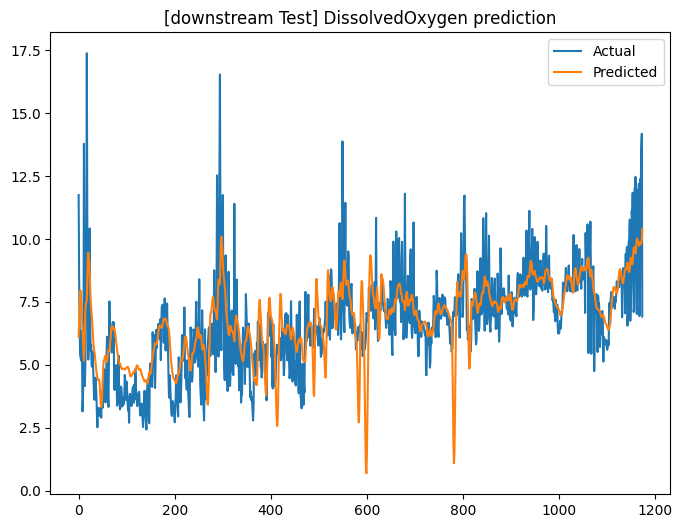

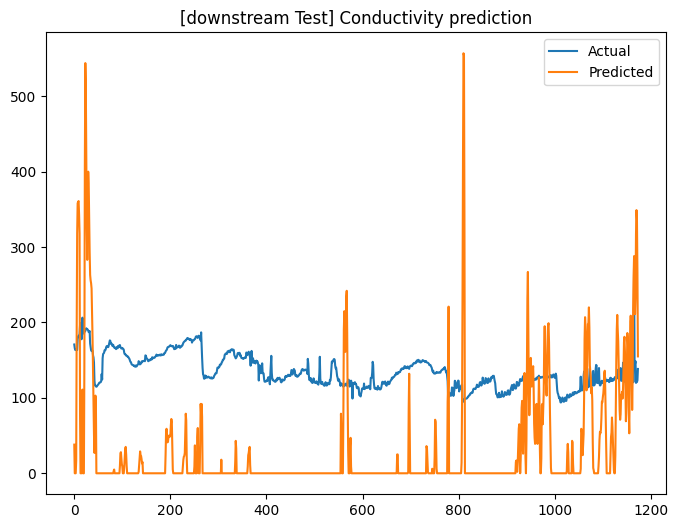

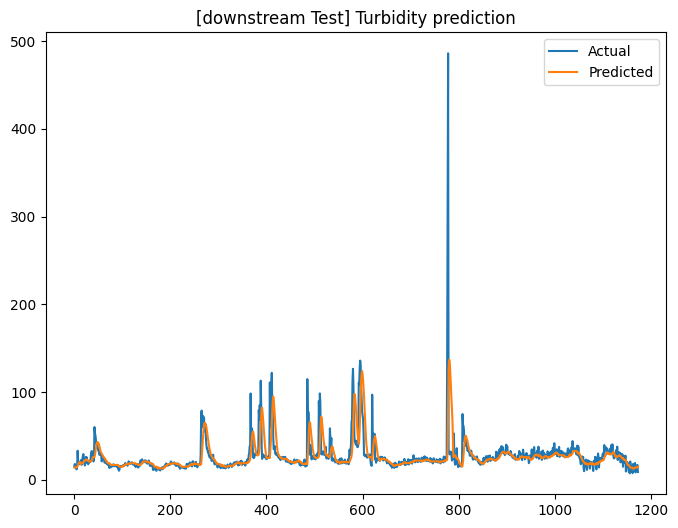

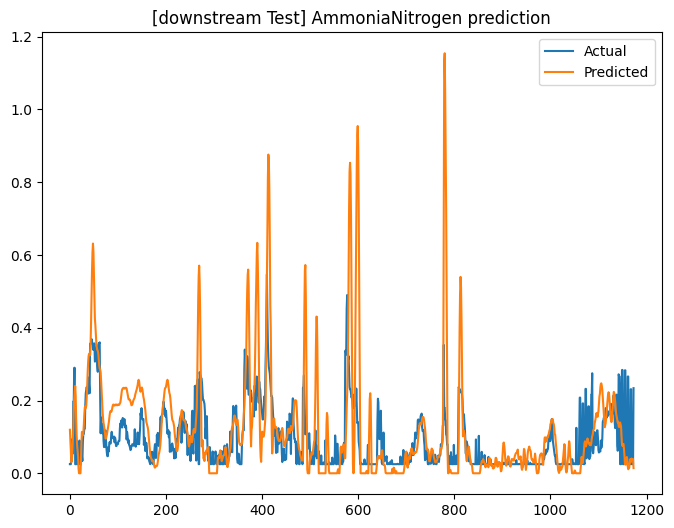

In [55]:
global_model, history, x_scaler, y_scaler = make_pipeline()

In [56]:
val_nrmses

{'fednova2': {'upstream': 0.9061026255800192,
  'midstream': 0.8542392232014242,
  'downstream': 0.959174518618546}}

In [57]:
test_nrmses

{'fednova2': {'upstream': 1.3303598136615828,
  'midstream': 0.9506704535764042,
  'downstream': 1.0266414610361831}}

In [58]:
def plot_hist(x, title=None, is_metric=False, target=None):
    assert target in ["RMSE", "MAE", "NRMSE", None]
    if isinstance(x, dict) and not is_metric:
        for bs in x:
            plt.plot(x[bs].values(), label=str(bs))
        plt.legend()
    
    elif is_metric:
        for bs in x:
            bs_hist = list(x[bs].values())
            hist_list = []
            for epoch in bs_hist:
                for k in epoch:
                    if k == target:
                        hist_list.append(epoch[k])
            plt.plot(hist_list, label=str(bs))
        plt.legend()
            
    else:
        plt.plot(x)
    if title is not None:
        plt.title(title)
    
    plt.show()
    plt.close()

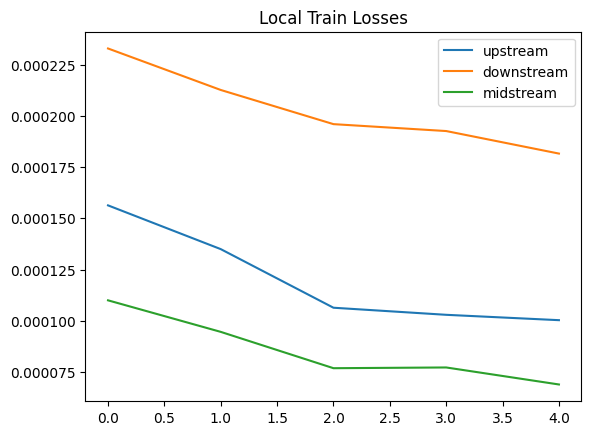

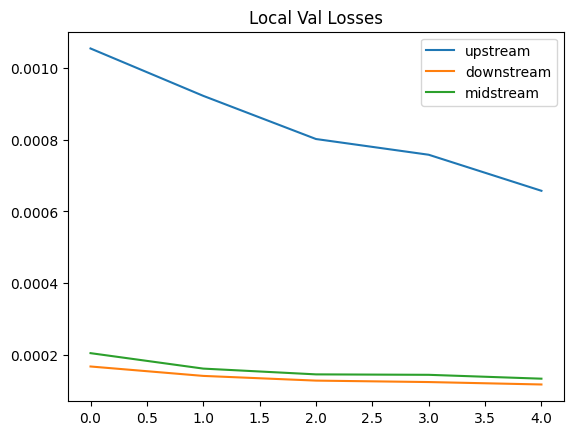

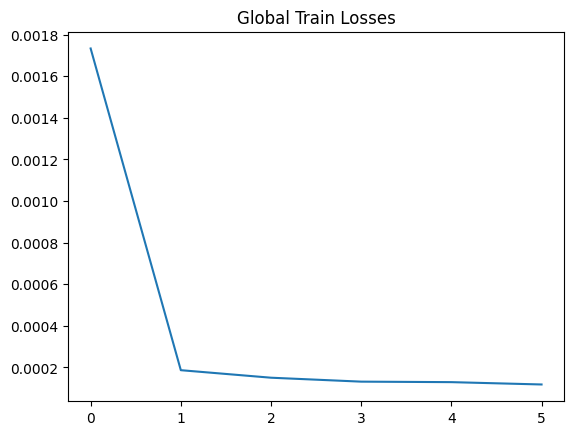

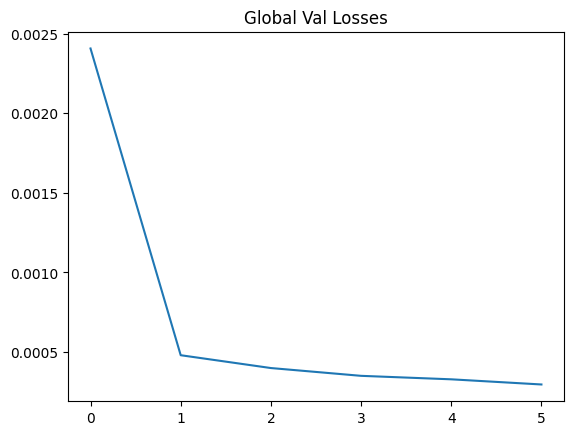

In [59]:
plot_hist(history.local_train_losses, title="Local Train Losses")
plot_hist(history.local_test_losses, title="Local Val Losses")
plot_hist(history.global_train_losses, title="Global Train Losses")
plot_hist(history.global_test_losses, title="Global Val Losses")

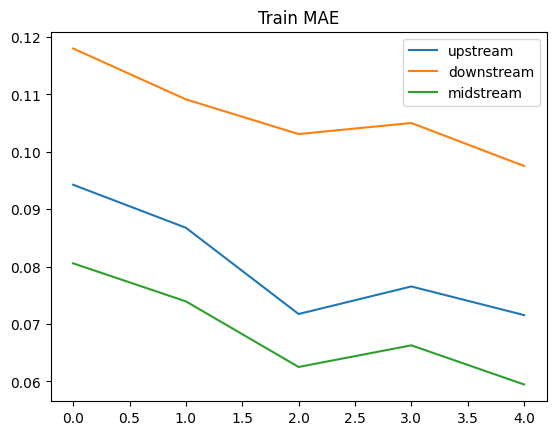

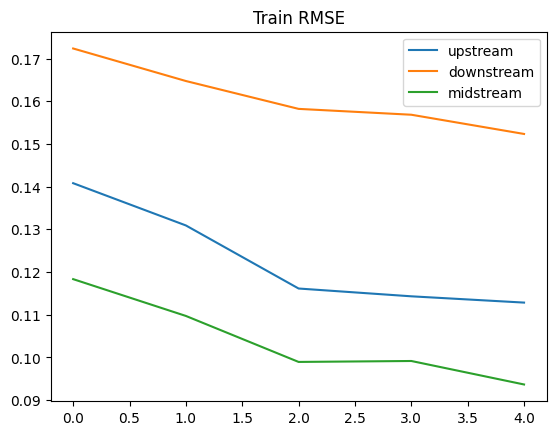

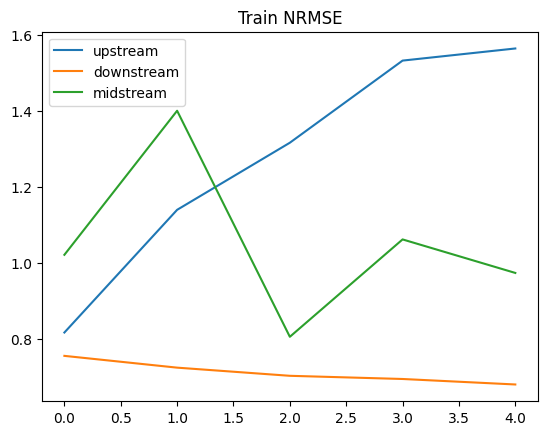

In [60]:
plot_hist(history.local_train_metrics, title="Train MAE", is_metric=True, target="MAE")
plot_hist(history.local_train_metrics, title="Train RMSE", is_metric=True, target="RMSE")
plot_hist(history.local_train_metrics, title="Train NRMSE", is_metric=True, target="NRMSE")

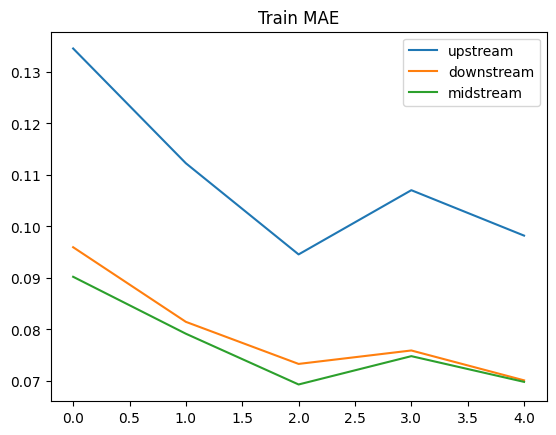

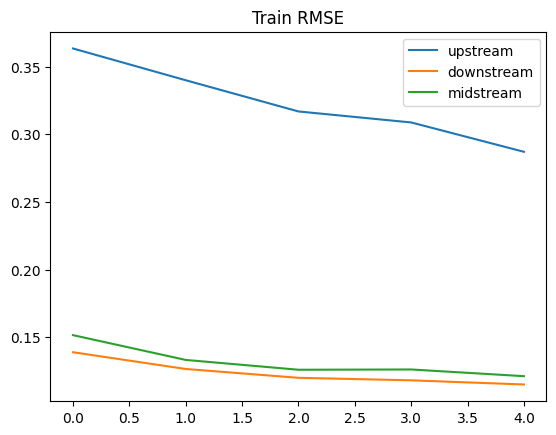

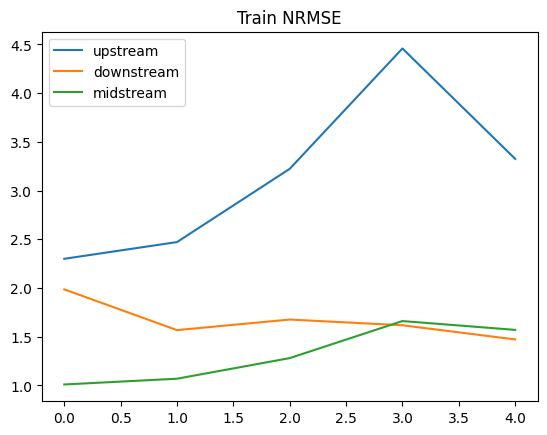

In [61]:
plot_hist(history.local_test_metrics, title="Train MAE" ,is_metric=True, target="MAE")
plot_hist(history.local_test_metrics, title="Train RMSE", is_metric=True, target="RMSE")
plot_hist(history.local_test_metrics, title="Train NRMSE", is_metric=True, target="NRMSE")

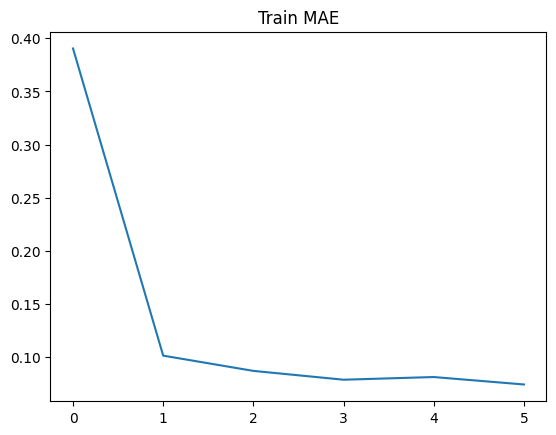

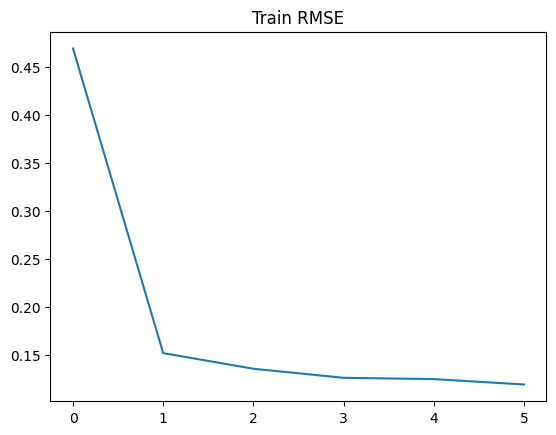

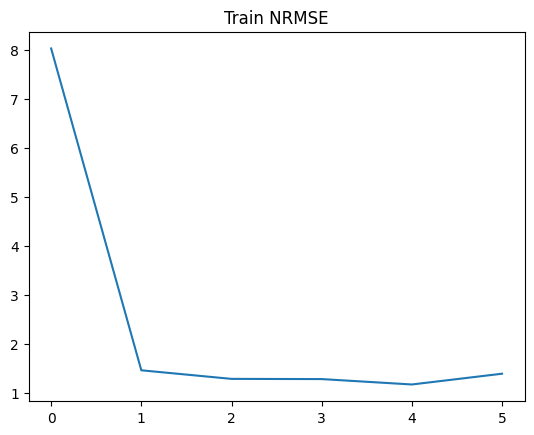

In [62]:
plot_hist(history.global_train_metrics["MAE"], title="Train MAE", )
plot_hist(history.global_train_metrics["RMSE"], title="Train RMSE", )
plot_hist(history.global_train_metrics["NRMSE"], title="Train NRMSE", )

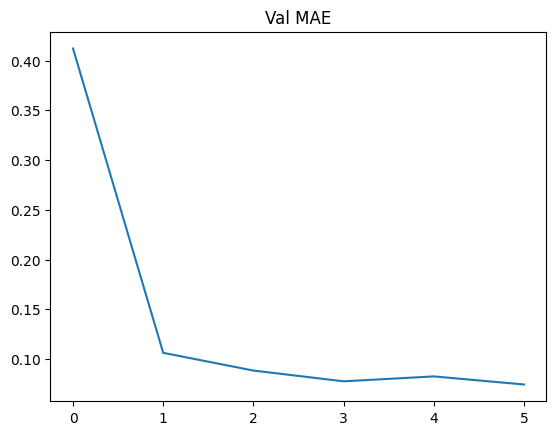

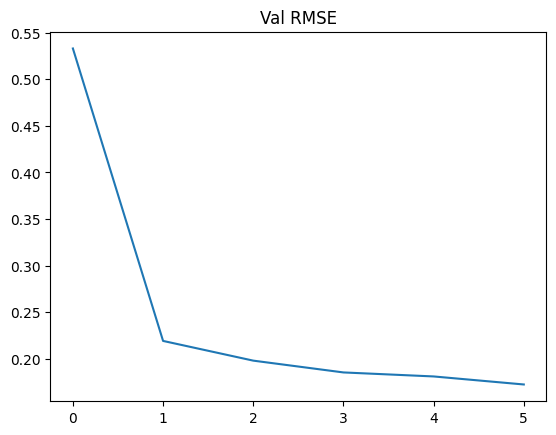

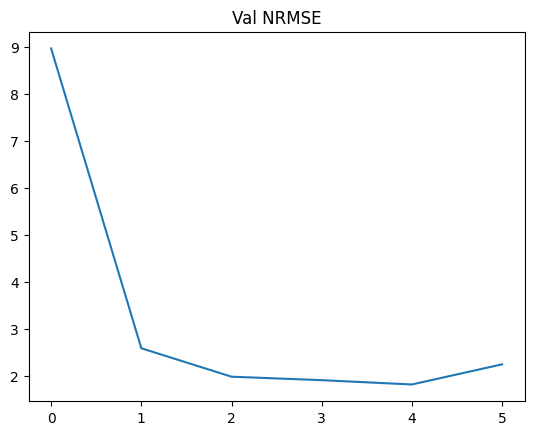

In [63]:
plot_hist(history.global_test_metrics["MAE"], title="Val MAE")
plot_hist(history.global_test_metrics["RMSE"], title="Val RMSE")
plot_hist(history.global_test_metrics["NRMSE"], title="Val NRMSE")

In [64]:
global_model

LSTM(
  (lstm): LSTM(9, 128, batch_first=True)
  (attention): Attention(
    (attention): Linear(in_features=128, out_features=1, bias=True)
  )
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [65]:
import h5py

In [66]:
class ModelSerializer:
    def __init__(self, 
                 model_state, 
                 save_path: str):
        self.model_state = model_state
        self.save_path = save_path

    def save(self):
        np_weights = self.state_to_numpy(self.model_state)
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("model_weights", track_order=True)
            for k, v in np_weights.items():
                group[k] = v
            

    @staticmethod
    def state_to_numpy(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) == np.ndarray:
            return model_state
        np_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            np_ordered_dict[k] = v.cpu().numpy().astype(np.float64)
        return np_ordered_dict

In [67]:
serializer = ModelSerializer(global_model.state_dict(), save_path="model_checkpoint/LSTM_FL_FedNova_weights_bs128_c1.h5")

In [68]:
serializer.save()

In [69]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

In [70]:
def get_minmax_attrs(scaler):
    scaler_attrs = dict()
    scaler_attrs["min_"] = scaler.min_
    scaler_attrs["scale_"] = scaler.scale_
    scaler_attrs["data_min_"] = scaler.data_min_
    scaler_attrs["data_max_"] = scaler.data_max_
    scaler_attrs["data_range_"] = scaler.data_range_
    scaler_attrs["n_features_in_"] = np.array([scaler.n_features_in_])
    scaler_attrs["n_samples_seen_"] = np.array([scaler.n_samples_seen_])
    scaler_attrs["feature_names_in_"] = scaler.feature_names_in_
    
    print(scaler_attrs)
    
    return scaler_attrs

In [71]:
class ScalerSerializer:
    def __init__(self, 
                 x_scaler_state,
                 y_scaler_state,
                 save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("x_scaler", track_order=True)
            for k, v in self.x_scaler.items():
                group[k] = v
            group=f.create_group("y_scaler", track_order=True)
            for k, v in self.y_scaler.items():
                group[k] = v
            

In [72]:
x_scaler_attrs = get_minmax_attrs(x_scaler)
print("\n\n")
y_scaler_attrs = get_minmax_attrs(y_scaler)

{'min_': array([ 0.        , -2.5098042 , -0.47619045, -0.01033705, -0.28509676,
        0.0363901 ,  0.3170577 ,  0.465571  ,  0.0276022 ], dtype=float32), 'scale_': array([2.6983269e-02, 3.9215690e-01, 1.3605441e-01, 8.5863037e-05,
       4.0024813e-02, 3.6390103e-02, 3.1705770e-01, 4.6557099e-01,
       2.7602198e-02], dtype=float32), 'data_min_': array([  0.   ,   6.4  ,   3.5  , 120.39 ,   7.123,  -1.   ,  -1.   ,
        -1.   ,  -1.   ], dtype=float32), 'data_max_': array([3.7060001e+01, 8.9499998e+00, 1.0850000e+01, 1.1766845e+04,
       3.2107502e+01, 2.6480000e+01, 2.1540000e+00, 1.1479000e+00,
       3.5229000e+01], dtype=float32), 'data_range_': array([3.7060001e+01, 2.5499997e+00, 7.3500004e+00, 1.1646455e+04,
       2.4984501e+01, 2.7480000e+01, 3.1540000e+00, 2.1479001e+00,
       3.6229000e+01], dtype=float32), 'n_features_in_': array([9]), 'n_samples_seen_': array([11771]), 'feature_names_in_': array(['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity',
      

In [73]:
serializer = ScalerSerializer(x_scaler_attrs, y_scaler_attrs, save_path="model_checkpoint/scalers.h5")
serializer.save()